In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import clone_model, Model
from sklearn.model_selection import train_test_split

In [2]:
import os

In [3]:
for dirpath, dirnames, filenames in os.walk("/kaggle/input/brain-tumor-mri-dataset"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '/kaggle/input/brain-tumor-mri-dataset'.
There are 4 directories and 0 images in '/kaggle/input/brain-tumor-mri-dataset/Training'.
There are 0 directories and 1457 images in '/kaggle/input/brain-tumor-mri-dataset/Training/pituitary'.
There are 0 directories and 1595 images in '/kaggle/input/brain-tumor-mri-dataset/Training/notumor'.
There are 0 directories and 1339 images in '/kaggle/input/brain-tumor-mri-dataset/Training/meningioma'.
There are 0 directories and 1321 images in '/kaggle/input/brain-tumor-mri-dataset/Training/glioma'.
There are 4 directories and 0 images in '/kaggle/input/brain-tumor-mri-dataset/Testing'.
There are 0 directories and 300 images in '/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary'.
There are 0 directories and 405 images in '/kaggle/input/brain-tumor-mri-dataset/Testing/notumor'.
There are 0 directories and 306 images in '/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma'.
There are 0 directories and 30

In [4]:
PATH = '/kaggle/input/brain-tumor-mri-dataset'

test_dir = os.path.join(PATH, "Testing")
train_dir = os.path.join(PATH, "Training")

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [5]:
for images, labels in train_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Labels: {labels.numpy()}")

Images shape: (32, 224, 224, 3)
Labels shape: (32,)
Labels: [3 3 1 2 2 0 2 1 1 1 1 1 1 2 2 3 2 0 1 1 1 0 0 3 3 1 1 2 1 3 3 3]


In [6]:
class_names = train_dataset.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


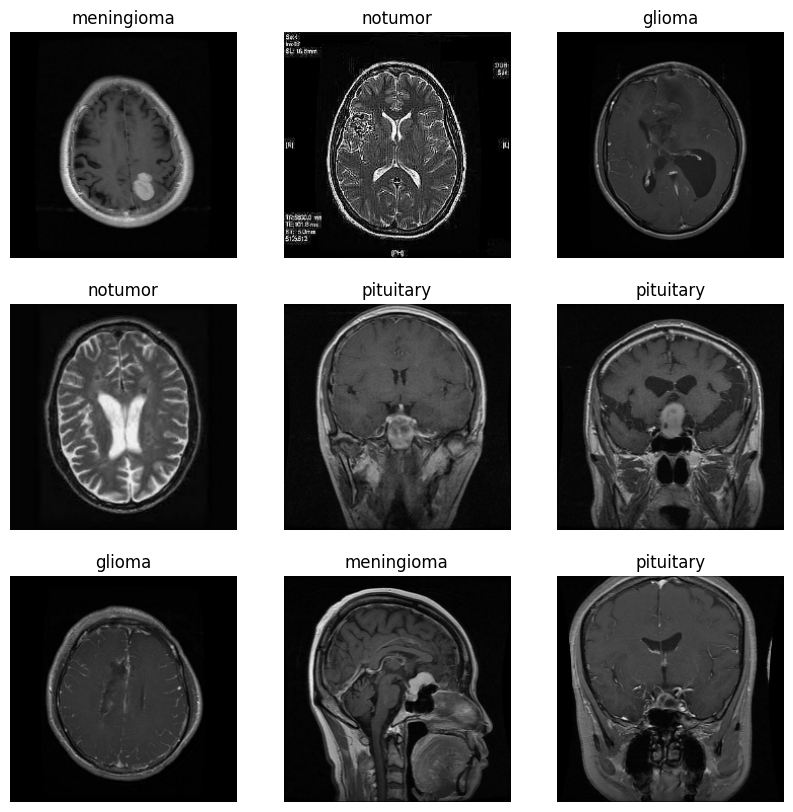

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(4* val_batches // 5)
validation_dataset = validation_dataset.skip(4* val_batches // 5)

In [9]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 179
Number of validation batches: 9
Number of test batches: 32


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [11]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [13]:
base_model.trainable = False

In [14]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


global average take average of each 7*7 so 1280

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
prediction_layer = tf.keras.layers.Dense(4, activation='softmax')

prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [18]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])

In [19]:
dropout_layer = tf.keras.layers.Dropout(0.2)

Functional API

In [20]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = dropout_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

1280*4+4=5124

In [22]:
len(model.trainable_variables)

2

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

In [24]:
loss0, accuracy0 = model.evaluate(validation_dataset)

9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 827ms/step - accuracy: 0.2189 - loss: 1.9523


In [25]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                    factor=0.5,
                                                    patience=3,
                                                    min_lr=1e-6)

In [26]:
initial_epochs = 5

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[lr_scheduler])

Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 166s 899ms/step - accuracy: 0.3588 - loss: 1.4798 - val_accuracy: 0.5889 - val_loss: 1.0450 - learning_rate: 1.0000e-04
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 160s 895ms/step - accuracy: 0.6908 - loss: 0.8415 - val_accuracy: 0.7352 - val_loss: 0.7814 - learning_rate: 1.0000e-04
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 162s 903ms/step - accuracy: 0.7664 - loss: 0.6546 - val_accuracy: 0.7456 - val_loss: 0.6716 - learning_rate: 1.0000e-04
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 161s 898ms/step - accuracy: 0.8069 - loss: 0.5698 - val_accuracy: 0.7631 - val_loss: 0.6364 - learning_rate: 1.0000e-04
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 162s 902ms/step - accuracy: 0.8186 - loss: 0.5145 - val_accuracy: 0.7596 - val_loss: 0.6656 - learning_rate: 1.0000e-04


In [27]:
loss, accuracy = model.evaluate(test_dataset)
print('Test loss :', loss)
print('Test accuracy :', accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 782ms/step - accuracy: 0.7949 - loss: 0.5930
Test loss : 0.605631947517395
Test accuracy : 0.7763671875


In [28]:
history_df = pd.DataFrame(history.history)

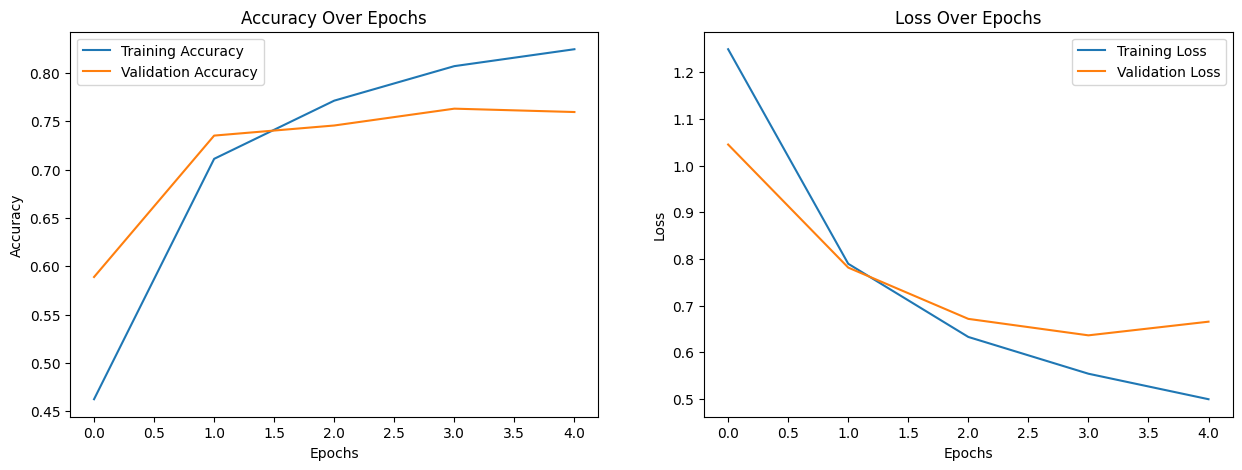

In [29]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [30]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []
for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

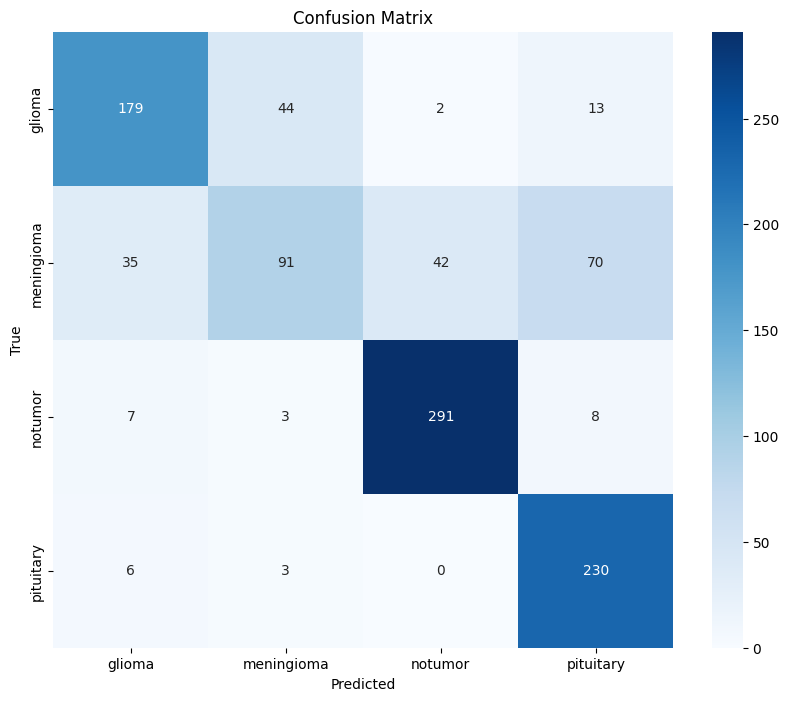

In [31]:
# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [32]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [33]:
base_model.trainable = True

In [34]:
fine_tune_at = 120

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [35]:
len(model.trainable_variables)

38

In [36]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=["accuracy"])

In [37]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 1,630,020 (6.22 MB)

 Non-trainable params: 633,088 (2.42 MB)

In [38]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset,
                         callbacks=[lr_scheduler])

Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.7498 - loss: 0.6593 - val_accuracy: 0.7875 - val_loss: 0.6243 - learning_rate: 1.0000e-05
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.8489 - loss: 0.3965 - val_accuracy: 0.7770 - val_loss: 0.6785 - learning_rate: 1.0000e-05
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.8787 - loss: 0.3412 - val_accuracy: 0.8014 - val_loss: 0.5283 - learning_rate: 1.0000e-05
Epoch 9/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.8955 - loss: 0.2838 - val_accuracy: 0.8188 - val_loss: 0.4947 - learning_rate: 1.0000e-05
Epoch 10/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9024 - loss: 0.2515 - val_accuracy: 0.8467 - val_loss: 0.4409 - learning_rate: 1.0000e-05


In [39]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 782ms/step - accuracy: 0.8533 - loss: 0.4170
Test accuracy : 0.865234375


In [40]:
history_fine_df = pd.DataFrame(history_fine.history)
history_fine_df.index += len(history_df)

In [41]:
history_full_df = pd.concat([history_df, history_fine_df])

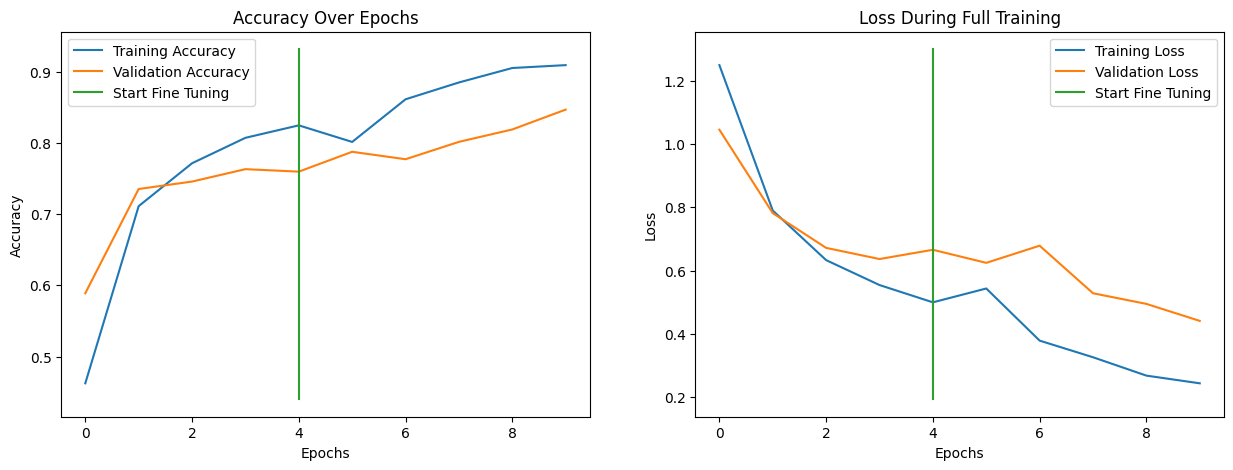

In [42]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_full_df['accuracy'], label='Training Accuracy')
plt.plot(history_full_df['val_accuracy'], label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_full_df['loss'], label='Training Loss')
plt.plot(history_full_df['val_loss'], label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.title("Loss During Full Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [43]:
y_true = []
y_pred = []
for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

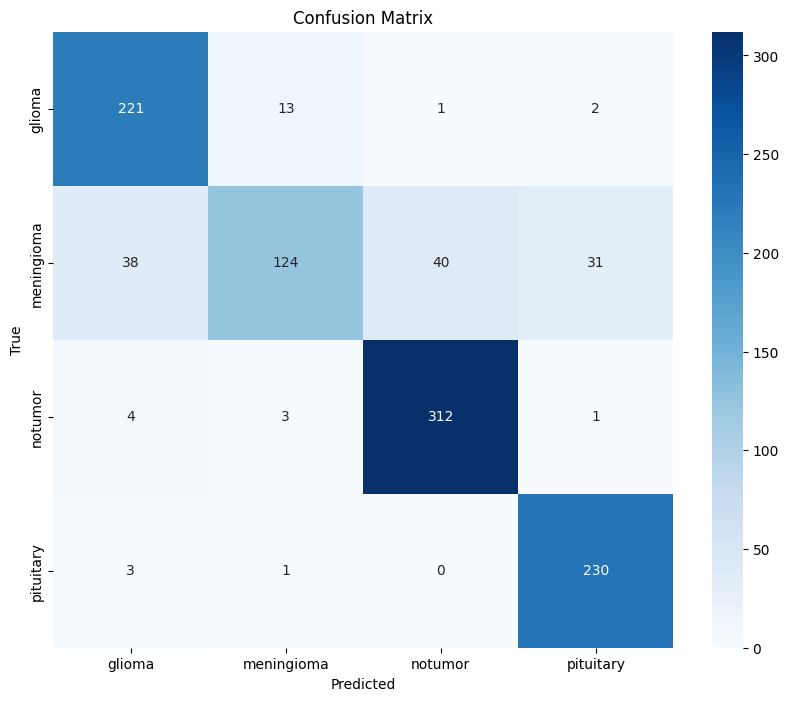

In [44]:
# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Predictions:
 [3 0 0 2 2 2 3 2 3 2 2 3 1 0 0 3 0 0 0 0 0 3 0 3 0 0 2 2 3 2 0 3]
Labels:
 [3 2 0 2 2 2 3 2 3 2 2 3 1 0 0 3 0 0 0 1 0 3 0 3 1 0 2 2 3 2 0 3]


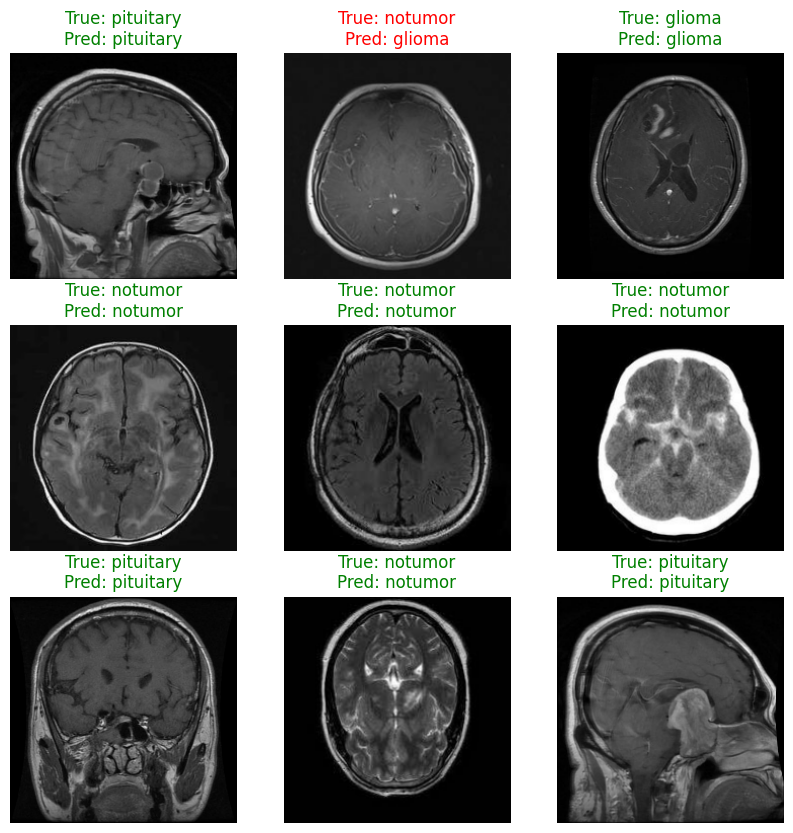

In [45]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predicted_classes = np.argmax(predictions, axis=1)

print('Predictions:\n', predicted_classes)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  true_label = class_names[label_batch[i]]
  predicted_label = class_names[predicted_classes[i]]
  plt.title(f"True: {true_label}\nPred: {predicted_label}", color="green" if true_label == predicted_label else "red")
  plt.axis("off")